In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties


import cv2
import os
import pickle
import random

from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure

from pathlib import Path

from keras.preprocessing import image
from keras.utils import np_utils


# Preprocessing Data

In [2]:
p = Path("./data/pokemon/")
dirs = p.glob("*")

def collecting_image(dirs):
    """
        dirs - directories in a certain path folder.
        Takes png files in each directory and returns to a rgb matrix.
        If a png file is none, remove the png file.
        os.remove() will clean all broken png files.
    """
    image_data = []
    labels = []
    for folder in sorted(dirs):
        label = str(folder).split('/')[-1]
        count = 0
        count1 = 0 
        # Taking all png files in img_path (a pokemon folder)
        for img_path in folder.glob("*.png"):
            img_path = str(img_path)
            img = cv2.imread(img_path) 
            if img is not None:
                img = cv2.resize(img,(96,96)) # Resize an image to 96 pixels by 96 pixels
                img_array = image.img_to_array(img) # Convert an image to an array
                image_data.append(img_array)
                labels.append(label)
                count += 1
            else:
                print(img_path)
                os.remove(img_path)
                print("File Removed")
                count1 += 1
    print('# of Images: {} for {}'.format(count, label)) 
    print("# of Removed Images", count1)
    
    return(image_data, labels)


In [3]:
# image_data, labels = collecting_image(dirs)

# of Images: 251 for Zubat
# of Removed Images 0


# Saving Pokemon Label Dictionary to pickle


In [16]:
# labels_dict = {key: val for key, val in enumerate(sorted(set(labels)), 0)}
# pickle.dump(labels_dict, open("data/pokemon_label.p", 'wb'))
# pickle.dump(image_data, open("data/image_data.p", 'wb'))
# pickle.dump(labels, open("data/labels.p", 'wb'))

# Train Test Data Split

In [3]:
labels_dict = pickle.load(open("data/pokemon_label.p", 'rb'))
image_data = pickle.load(open('data/image_data.p','rb'))
labels = pickle.load(open('data/labels.p','rb'))

In [4]:
X = np.array(image_data)
y = np.array(labels)
print(X.shape)
print(y.shape)

(42023, 96, 96, 3)
(42023,)


In [5]:
def drawImg(img,label):
    """ 
        Draw an input image with a label
    """
    plt.title(label)
    plt.imshow(img)
    plt.show()

In [6]:
def pokemon_to_keys(y,labels_dict):
    """ y - list of pokemons
        labels_dict - {(0,151):'pokemon'}
        returns to corresponding key.
        
    """
    new_y = []
    for y_element in y:
        for k, v in labels_dict.items():
            if y_element == v:
                new_y.append(k)
    return(np.array(new_y))

In [7]:
# Splitting Train Test data by sklearn.train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# 'float32' type data is more efficiently trained in a neural network. Also can be normalized.
# Normalizing Data
X_train = X_train.astype('float32') / 255.0 
X_test = X_test.astype('float32') / 255.0

y_train = pokemon_to_keys(y_train, labels_dict)
y_test = pokemon_to_keys(y_test, labels_dict)

In [8]:
print(X_train.shape)
print(X_test.shape)
assert (X_train.shape[0] + X_test.shape[0] == X.shape[0])

(33618, 96, 96, 3)
(8405, 96, 96, 3)


In [7]:
from collections import Counter

pokemons, counts = zip(*Counter(y).items())
df_images = pd.DataFrame(index=pokemons, data={'# of Images':counts})
df_images.head()

,# of Images
Abra,204
Aerodactyl,764
Alakazam,722
Arbok,607
Arcanine,590


## Generate Some Random Pokemons

In [9]:
def random_pokemon_key(key, array):
    return int(random.choice(np.argwhere(array == key)))

In [16]:
def display_sample_pokemons(samples_indices, img_array, labels, pred_labels=None, pred_probs=None):
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]

            ax[row,col].imshow(img_array[index])
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 80),96,16,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(20,80, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            if (pred_labels!= None and pred != None):
                pred_label = labels_dict[pred_labels[index]]
                pred_prob = max(pred_probs[index])*100
                pred_text = "{} : {:.0f}%".format(pred_label,pred_prob)
                ax[row,col].text(20, 88, pred_text , horizontalalignment='left', fontproperties=font,
                                 verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

In [11]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y_train) for key in rand_pokemon_keys]

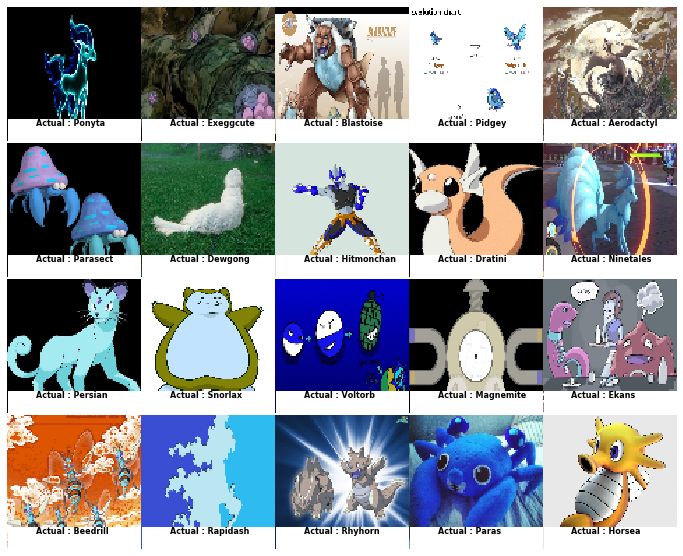

In [17]:
display_sample_pokemons(samples_indices, X_train, y_train)

## Converting a class vector (integers) to a binary class matrix

In [167]:
num_classes = 151
y_train = np_utils.to_categorical(y_train, num_classes, dtype='float32')
y_test = np_utils.to_categorical(y_test, num_classes, dtype='float32')

# Data Augmentation

Data Augmemntation changes an input image in variety ways such as flipping horizontally/vertically or changing brightness of image, so that I can prevent overffiting from a model.

In [ ]:
#https://keras.io/preprocessing/image/

# Histogram of Oriented Gradients

\*Calculates a gradient magnitude between horizontal gradient and vertical gradient of corresponding pixel's intensity value and a angle between them by arctan(grad_y/ grad_x) in each window of an image

In [54]:
def display_hog_sample_pokemons(samples_indices, img_array, labels):
    n = 0
    nrows = 4
    ncols = 5
    assert (len(samples_indices) == nrows * ncols)
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]
            gray = cv2.cvtColor(img_array[index], cv2.COLOR_BGR2GRAY)
            # Compute the gradient vector or edge orientations at each pixel
            fd, hog_img = hog(gray, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, block_norm='L1')
            
            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10))
        
        
            ax[row,col].imshow(hog_image_rescaled)
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            ax[row,col].add_patch(patches.Rectangle((0, 80),96,16,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(20,80, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

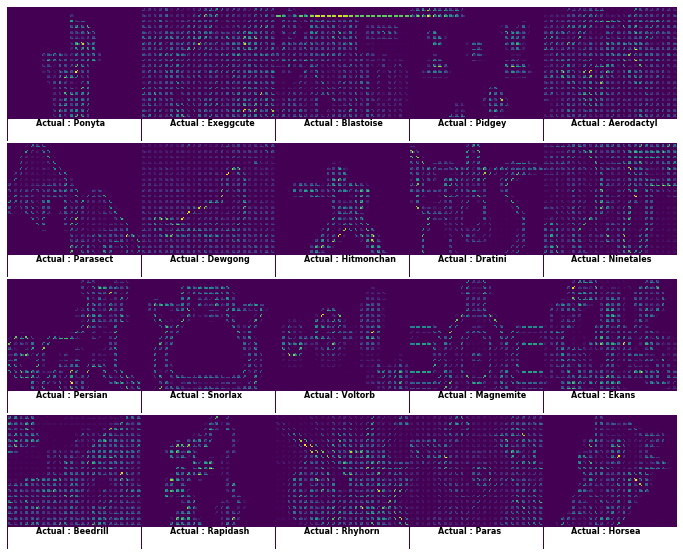

In [20]:
display_hog_sample_pokemons(samples_indices, X_train, y_train)

In [47]:
squirtle_keys = np.empty(20)
squirtle_keys.fill(129)

In [48]:
squirtle = [random_pokemon_key(key, y_train) for key in squirtle_keys]


In [28]:
pikachu_keys = np.empty(20)
pikachu_keys.fill(103)

In [30]:
pikachu = [random_pokemon_key(key, y_train) for key in pikachu_keys]

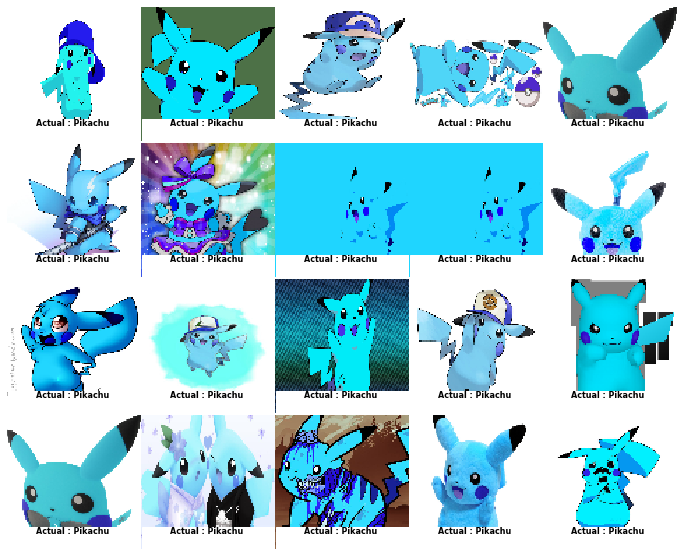

In [34]:
display_sample_pokemons(pikachu, X_train, y_train)

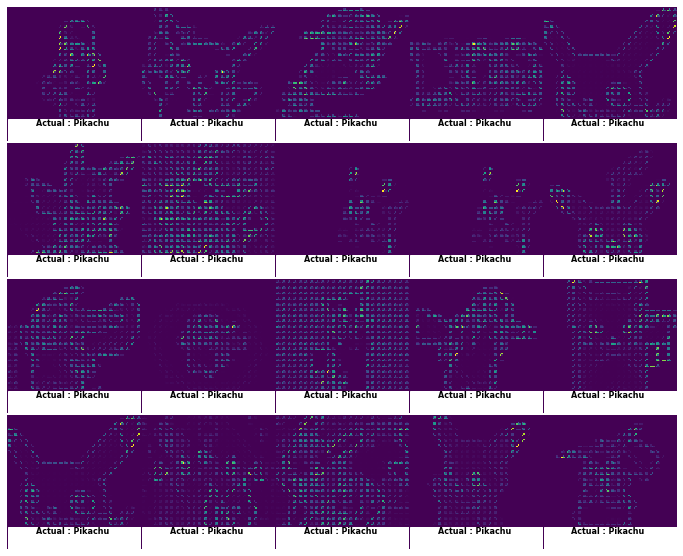

In [55]:
display_hog_sample_pokemons(pikachu, X_train, y_train)

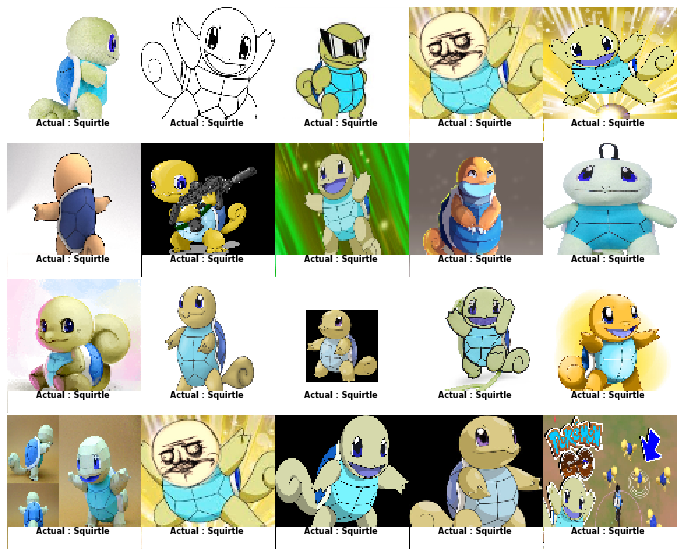

In [49]:
display_sample_pokemons(squirtle, X_train, y_train)


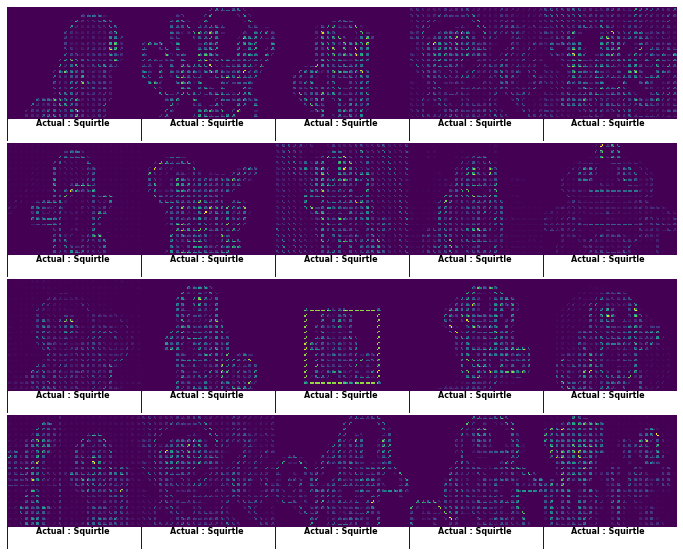

In [51]:
display_hog_sample_pokemons(squirtle, X_train, y_train)